In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import dicom
import os
import scipy.ndimage
import cv2
import time
import scipy.misc
import caffe
import seaborn as sns

caffe_root = "./"
%matplotlib inline

size_image = (256, 216, 3)
sns.set_style("whitegrid", {'axes.grid' : False})

plt.rcParams['image.cmap'] = 'gray'

# Read training set

In [2]:
# rep_traininSet = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/IRM/"
# rep_label = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/Segment_GT/" 

rep_traininSet = "/home/luffy/Documents/Stage/dataSet_preprocess/Train_augmented/IRM/"
rep_label = "/home/luffy/Documents/Stage/dataSet_preprocess/Train_augmented/Segment_GT/" 

fileList = [f for f in list(os.walk(rep_traininSet))[0][2] if ".png" in f.lower()][:1000]

nb_image = 0
images_irm = np.zeros((size_image[0], size_image[1], size_image[2], len(fileList)))
labels = np.zeros((size_image[0], size_image[1], len(fileList)))

for filename in fileList:
    images_irm[:,:, :,nb_image] = scipy.misc.imread(rep_traininSet + filename)
    labels[:,:, nb_image] = scipy.misc.imread(rep_label + filename)
    nb_image += 1
            

# Read test set

In [ ]:
rep_testSet = "/home/luffy/Documents/Stage/dataSet_preprocess/Test/IRM/"
rep_label_test = "/home/luffy/Documents/Stage/dataSet_preprocess/Test/Segment_GT/" 

fileList = [f for f in list(os.walk(rep_testSet))[0][2] if ".png" in f.lower()]

nb_image = 0
images_irm_test = np.zeros((size_image[0], size_image[1], size_image[2], len(fileList)))
labels_test = np.zeros((size_image[0], size_image[1], len(fileList)))

for filename in fileList:
    images_irm_test[:,:, :,nb_image] = scipy.misc.imread(rep_testSet + filename)
    labels_test[:,:, nb_image] = scipy.misc.imread(rep_label_test + filename)
    nb_image += 1
            

## Test reading

In [ ]:
num_image = 10
img = images_irm[:,:,0,num_image]
label = labels[:,:,num_image]

plt.figure(figsize=(30,30))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original image")
plt.subplot(1,3,2)
plt.imshow(label)
plt.title("Ground truth segmentation")
plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(label, alpha=0.5)
plt.title("Superposition")

In [ ]:
np.unique(label)

# Training

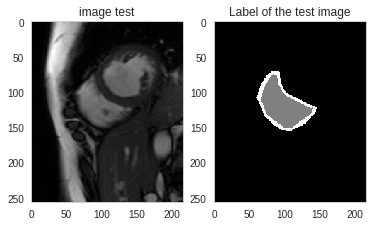

In [2]:
from IPython import display
import time 


solver_name = caffe_root + "models/bvlc_alexnet_FCN_wTOPO/solver_alexnet_fcn_topo2loss.prototxt"
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver(solver_name)

# rep_model = "/media/luffy/DATA/Users/abdel/models_pretrained_rv_softmax/"
rep_model = caffe_root
weight_softmax = rep_model + 'train_alexnet_Topo_pretrained_softmax_iter_60000.caffemodel'
solver.net.copy_from(weight_softmax)

solver.step(1)

image_test = solver.test_nets[0].blobs["data"].data[0].transpose(1,2,0)
image_test_label = solver.test_nets[0].blobs["label"].data[0,0,:,:]
plt.subplot(1,2,1)
plt.imshow(image_test[:,:,0])
plt.title("image test")
plt.subplot(1,2,2)
plt.imshow(image_test_label)
plt.title("Label of the test image")

nb_step = 0

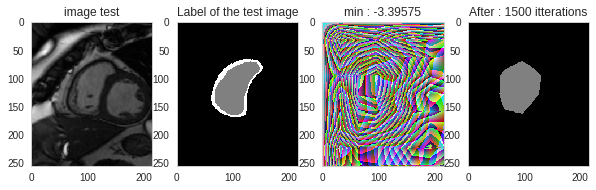

In [ ]:
step_size = 500
for i in range(20):
    solver.step(step_size)
    nb_step += step_size
    
    minimum = np.min(solver.test_nets[0].blobs["score-final"].data[0,:,:,:].transpose(1,2,0)[:,:,0])
    
    plt.figure(figsize=(10,10))
    image_test = solver.test_nets[0].blobs["data"].data[0].transpose(1,2,0)
    image_test_label = solver.test_nets[0].blobs["label"].data[0,0,:,:]
    plt.subplot(1,4,1)
    plt.imshow(image_test[:,:,0])
    plt.title("image test")
    plt.subplot(1,4,2)
    plt.imshow(image_test_label)
    plt.title("Label of the test image")
    plt.subplot(1,4,3)
    plt.imshow(solver.test_nets[0].blobs["score-final"].data[0,:,:,:].transpose(1,2,0))
    plt.title("min : " + str(minimum))
    plt.subplot(1,4,4)
    plt.imshow(solver.test_nets[0].blobs["score-final"].data[0,:,:,:].transpose(1,2,0).argmax(2), vmin=0, vmax=2)
    plt.title("After : " + str(nb_step) + " itterations")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)
    
#     print ("result : ", )


In [1]:
minimum = np.min(solver.test_nets[0].blobs["score-final_crop_0_split_0"].data[0,:,:,:].transpose(1,2,0))
maximum = np.min(solver.test_nets[0].blobs["score-final_crop_0_split_0"].data[0,:,:,:].transpose(1,2,0))
out = (solver.test_nets[0].blobs["score-final_crop_0_split_0"].data[0,:,:,:].transpose(1,2,0) - minimum)/maximum

NameError: name 'np' is not defined

In [ ]:
solver.test_nets[0].blobs["score-final_crop_0_split_0"].data[0,:,:,:].transpose(1,2,0)

In [ ]:
# for each layer, show the output shape
for layer_name, blob in solver.net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

# TEST

In [ ]:
model_def = caffe_root + 'models/bvlc_alexnet_FCN_wTOPO/my_alexnet_fcn_deploy.prototxt'
# model_weights = caffe_root + 'models/bvlc_alexnet_FCN_wTOPO/alexnet_LT.caffemodel'
model_weights = 'train_alexnet_Topo_pretrained_iter_46000.caffemodel'


net = caffe.Net(model_def,      # defines the structure of the model
                model_weights)     # use test mode (e.g., don't perform dropout)

net.set_phase_test()
net.set_device(0)
net.set_mode_cpu()

## Result on the training set

In [ ]:
import random

nb_images = images_irm.shape[3]
indices = list(range(nb_images))
images_to_test = indices[:100]

for num_image_train in images_to_test:
    img = images_irm[:,:,:,num_image_train].transpose(2,0,1)
    label = labels[:,:, num_image_train]

    net.blobs['data'].data[...] = img
    net.forward()
    
    out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
    label_out = out.argmax(axis=2)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(img.transpose(1,2,0))
    plt.title("Orginial image")
    plt.subplot(1,3,2)
    plt.imshow(label, vmin=0, vmax=2)
    plt.title("Ground truth segmentation")
    plt.subplot(1,3,3)
    plt.imshow(label_out, vmin=0, vmax=2)
    plt.title("Segmentation predicted")

## Results on the test set

In [ ]:
# labels_test_predicted = np.zeros(images_irm_test.shape)

# for num_image_test in range(images_test_predicted.shape[2]):
#     img = images_irm_test[:,:,:,num_image_test].transpose(2,0,1)
#     label = labels_test[:,:, num_image_test]

#     net.blobs['data'].data[...] = img
#     net.forward()
    
#     out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
#     labels_test_predicted[:,:,:,num_image_test] = out.argmax(axis=2)

In [ ]:
import random

nb_images = images_irm_test.shape[3]
indices = list(range(nb_images))
images_to_test = indices

for num_image_test in images_to_test:
    img = images_irm_test[:,:,:,num_image_test].transpose(2,0,1)
    label = labels_test[:,:, num_image_test]

    net.blobs['data'].data[...] = img
    net.forward()
    
    out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
    label_out = out.argmax(axis=2)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(img.transpose(1,2,0)[:,:,0], vmin=0, vmax=255)
    plt.title("Orginial image")
    plt.subplot(1,4,2)
    plt.imshow(label, vmin=0, vmax=2)
    plt.title("Ground truth segmentation")
    plt.subplot(1,4,3)
    plt.imshow(out)
    plt.title("Heat map")
    plt.subplot(1,4,4)
    plt.imshow(label_out, vmin=0, vmax=2)
    plt.title("Segmentation predicted")

### Depending on the number of itterations done

#### Load all the nets

In [ ]:
nb_itterations = [2000, 10000, 20000, 30000, 40000, 46000]

model_def = caffe_root + 'models/bvlc_alexnet_FCN_wTOPO/my_alexnet_fcn_deploy.prototxt'
rep_model = "/media/luffy/DATA/Users/abdel/models_pretrained_rv_softmax/"

nets = []

for nb_itter in nb_itterations:
    model_weights = rep_model + 'train_alexnet_Topo_pretrained_iter_' + str(nb_itter) +'.caffemodel'
    net = caffe.Net(model_def, model_weights)  
    net.set_phase_test()
    net.set_device(0)
    net.set_mode_cpu()
    nets.append(net)

In [ ]:
nbs_nets = len(nets)
nb_columns_display = 2 + nbs_nets

for num_image_test in range(images_irm_test.shape[3]):
    img = images_irm_test[:,:,:,num_image_test].transpose(2,0,1)
    label = labels_test[:,:, num_image_test]

    plt.figure(figsize=(30,30))
    plt.subplot(1,nb_columns_display,1)
    plt.imshow(img.transpose(1,2,0)[:,:,0], vmin=0, vmax=255)
    plt.title("Orginial image")
    plt.subplot(1,nb_columns_display,2)
    plt.imshow(label, vmin=0, vmax=2)
    plt.title("Ground truth segmentation")
    for i, net in enumerate(nets):
        net.blobs['data'].data[...] = img
        net.forward()
        out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
        label_out = out.argmax(axis=2)
        plt.subplot(1,nb_columns_display,2+i+1)
        plt.imshow(label_out, vmin=0, vmax=2)
        plt.title("Segmentation predicted after " + str (nb_itterations[i]))

#### Pixel wise accuaracy depending on the number of itterations done

In [ ]:
accuaracy_depending_nbItterations = np.zeros(len(nets), dtype=np.float)

for num_image_test in range(images_irm_test.shape[3]):
    img = images_irm_test[:,:,:,num_image_test].transpose(2,0,1)
    label = labels_test[:,:, num_image_test]
    for i, net in enumerate(nets):
        net.blobs['data'].data[...] = img
        net.forward()
        out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
        label_predicted = out.argmax(axis=2)
        accuaracy_depending_nbItterations[i] += np.sum((label == label_predicted).astype(int))/float(label.size)

accuaracy_depending_nbItterations /= images_irm_test.shape[3]
        

In [ ]:
plt.plot(nb_itterations, accuaracy_depending_nbItterations)
plt.title("Pixel wise accuaracy depending on the number of itterations done")

In [ ]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)